<h1>Exploring the statsbomb data</h1>



In [1]:
import os

# Change to the parent directory
os.chdir('..')

import socceraction.spadl as spadl
from socceraction.data.statsbomb import StatsBombLoader 
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
import warnings
warnings.filterwarnings('ignore') 
api = StatsBombLoader(getter="local", root="data/open-data-master/data")


Grabbing a test event to see if matching actor coordinate.

In [2]:
example_events = api.events(game_id=3788742,load_360=True)

Get 360 data and location

In [3]:
import numpy as np

event = example_events[7:8]

three_sixty_data = event.freeze_frame_360.item()
location = event.location.item()
team_id = event.team_id.item()

for player in three_sixty_data:
    if player['actor'] == True:
        print(f"Player Loation (360 Data): {player['location']}")
        print(f"Player Loation (Reg Data): {location}")
        print(f"Player Team ID: {team_id}")
        print(f"Time: {event.timestamp.item()}")



Player Loation (360 Data): [59.5, 40.0]
Player Loation (Reg Data): [59.5, 40.0]
Player Team ID: 776
Time: 0 days 00:00:02.163000


From what it appears the data aligns correctly. Now for the spadl intervention

In [4]:

FL, FW = 105.0, 68.0  # meters

def sb_to_spadl_xy(x, y, fidelity_version=None, assume_cell_center=False):
    """
    Convert a single StatsBomb (x,y) to SPADL meters.
    - If `assume_cell_center=True`, subtract half-cell. Use for old, integer-ish event coords.
    - For 360 freeze-frames, pass assume_cell_center=False (no center shift).
    """
    if assume_cell_center:
        cell_side = 0.1 if fidelity_version == 2 else 1.0
        x = x - cell_side/2.0
        y = y - cell_side/2.0

    x_m = np.clip(x / 120.0 * FL, 0, FL)
    y_m = np.clip(FW - (y / 80.0 * FW), 0, FW)
    return x_m, y_m

def ltr_flip_if_away(x_m, y_m, is_away):
    if is_away:
        return (FL - x_m, FW - y_m)
    return (x_m, y_m)

# Example: transform a 360 freeze-frame list `ff` for the same LTR convention as SPADL
def transform_freeze_frame(ff, is_away, fidelity_version=None):
    out = []
    for p in ff:
        x, y = p["location"]
        xm, ym = sb_to_spadl_xy(x, y, fidelity_version, assume_cell_center=True)  # key difference
        xm, ym = ltr_flip_if_away(xm, ym, is_away)
        q = dict(p)
        q["location_spadl"] = [xm, ym]
        out.append(q)
    return out




In [14]:
spadl_action = spadl.statsbomb.convert_to_actions(event, home_team_id=776)
spadl_action = (
  spadl
  .add_names(spadl_action)  # add actiontype and result names
  .merge(api.teams(game_id=3788742))  # add team names
  .merge(api.players(game_id=3788742))  # add player names
)
fidelity = spadl.statsbomb._infer_xy_fidelity_versions(event)[1]

spadl_action_l2r = spadl.play_left_to_right(spadl_action, home_team_id=776)

spadl_location = [spadl_action_l2r.start_x.item(), spadl_action_l2r.start_y.item()]
spadl_end_location = [spadl_action_l2r.end_x.item(), spadl_action_l2r.end_y.item()]

transformed_threesixty = transform_freeze_frame(three_sixty_data,is_away=False,fidelity_version=fidelity)

for player in transformed_threesixty:
    if player['actor'] == True:
        threesixty_location = player['location_spadl']
        print(f"Player Loation (Transformed 360 Data): {threesixty_location}")
        print(f"Player Loation (Spadl 360 Data): {spadl_location}")
        print(f"Player Team ID: {team_id}")
        print(f"Time (360 Data): {event.timestamp.item()}")
        print(f"Time (Spadl Data): {spadl_action.time_seconds.item()}")



spadl_action.type_name

Player Loation (Transformed 360 Data): [52.01875, 34.0425]
Player Loation (Spadl 360 Data): [52.01875, 34.0425]
Player Team ID: 776
Time (360 Data): 0 days 00:00:02.163000
Time (Spadl Data): 2.163


0    pass
Name: type_name, dtype: object

In [6]:
event2 = example_events[5:11]
spadl_action2 = spadl.statsbomb.convert_to_actions(event2, home_team_id=776)
spadl_action2 = (
  spadl
  .add_names(spadl_action2)  # add actiontype and result names
  .merge(api.teams(game_id=3788742))  # add team names
  .merge(api.players(game_id=3788742))  # add player names
)
spadl_action2


,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,...,result_name,bodypart_name,team_name,player_name,nickname,jersey_number,is_starter,starting_position_id,starting_position_name,minutes_played
0,3788742,1f666197-9b1a-4f44-9b88-972cad12cf14,1,1.411,776,3043.0,52.01875,35.0625,52.01875,34.0425,...,success,foot,Denmark,Christian Dannemann Eriksen,Christian Eriksen,10,True,13,Right Center Midfield,42
1,3788742,d1fceef9-831b-448e-a5fe-6bbf27d9d820,1,2.163,776,3043.0,52.01875,34.0425,58.58125,6.0775,...,success,foot_right,Denmark,Christian Dannemann Eriksen,Christian Eriksen,10,True,13,Right Center Midfield,42
2,3788742,f757411f-ca59-45d6-9e48-f85e2cacb806,1,3.781,776,6797.0,58.58125,6.0775,59.89375,5.6525,...,success,foot,Denmark,Daniel Wass,None,18,True,2,Right Back,77


In [7]:
"""import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D

# Class index mapping you suggested
COLORMAP = {
    'field': 0,
    'line': 1,
    'player_home': 2,
    'player_away': 3,
    'ball_start': 3,
    'ball_end': 3
}

# Colors for the background "mask" array (field/lines/home/away).
# (Points for players/ball are overlaid with scatter; these colors are mostly for the background array.)
CMAP_LIST = ['#2b8a3e', '#ffffff', '#9ecae1', '#fcae91']  # green field, white lines, pale home/away
cmap = ListedColormap(CMAP_LIST)
norm = BoundaryNorm(np.arange(len(CMAP_LIST)+1)-0.5, cmap.N)

FL, FW = 105.0, 68.0  # meters

def plot_frame(field_array,
               players,
               ball=None,
               ax=None,
               title=None,
               show_legend=True):
    """"""
    field_array: np.ndarray of ints with shape (105,68) or (68,105),
                 with values in {0..3} matching COLORMAP values
    players: list of dicts like StatsBomb 360: {'teammate': bool, 'actor': bool, 'location': [x,y]}
             (x,y) must already be in SPADL meters (0..105, 0..68)
    ball: None OR dict with optional 'start' and 'end' keys mapping to [x,y] in meters
          e.g., {'start': [60.0, 40.0], 'end': [66.2, 38.1]}
    """"""
    arr = np.asarray(field_array)
    if arr.shape == (105, 68):
        arr_plot = arr.T  # transpose to [rows(y), cols(x)]
    elif arr.shape == (68, 105):
        arr_plot = arr
    else:
        raise ValueError("field_array must be shape (105,68) or (68,105)")

    created_fig = False
    if ax is None:
        fig, ax = plt.subplots(figsize=(9, 6))
        created_fig = True

    # Background (field/lines/etc.)
    ax.imshow(arr_plot,
              origin='lower',
              extent=[0, FL, 0, FW],
              cmap=cmap, norm=norm,
              interpolation='nearest', alpha=0.95)

    # Minor grid (optional): 5m to help eyeball distances
    ax.set_xlim(0, FL); ax.set_ylim(0, FW)
    ax.set_aspect('equal')
    ax.set_xticks(np.arange(0, FL+1e-6, 5))
    ax.set_yticks(np.arange(0, FW+1e-6, 5))
    ax.grid(alpha=0.1, linewidth=0.5)

    # Overlay players
    home_x, home_y = [], []
    away_x, away_y = [], []
    actor_x, actor_y = [], []
    for p in players:
        x, y = p['location_spadl']
        if p.get('teammate', False):
            home_x.append(x); home_y.append(y)
        else:
            away_x.append(x); away_y.append(y)
        if p.get('actor', True):
            actor_x.append(x); actor_y.append(y)

    # Basic player scatter
    h_sc = ax.scatter(home_x, home_y, s=40, marker='o', edgecolor='black', linewidths=0.6, alpha=0.95, label='Home')
    a_sc = ax.scatter(away_x, away_y, s=40, marker='s', edgecolor='black', linewidths=0.6, alpha=0.95, label='Away')

    # Emphasize actor (ball carrier)
    if len(actor_x):
        ax.scatter(actor_x, actor_y, s=120, marker='*', edgecolor='black', linewidths=0.8,
                   alpha=1.0, label='Actor (on ball)')

    # Draw ball start/end (if provided)
    if isinstance(ball, dict):
        if 'start' in ball and ball['start'] is not None:
            bx, by = ball['start']
            ax.scatter([bx], [by], s=80, marker='o', facecolor='none', edgecolor='black',
                       linewidths=1.4, label='Ball start')
        if 'end' in ball and ball['end'] is not None:
            ex, ey = ball['end']
            ax.scatter([ex], [ey], s=80, marker='x', linewidths=1.6, label='Ball end')
            # optional arrow from start->end
            if 'start' in ball and ball['start'] is not None:
                bx, by = ball['start']
                ax.annotate("", xy=(ex, ey), xytext=(bx, by),
                            arrowprops=dict(arrowstyle="->", lw=1.2, alpha=0.9))

    # Labels / cosmetics
    ax.set_xlabel("Meters (x)"); ax.set_ylabel("Meters (y)")
    if title:
        ax.set_title(title)

    if show_legend:
        # Clean legend using proxy artists (so marker styles are consistent)
        proxy = [
            Line2D([0], [0], marker='o', color='w', label='Home', markerfacecolor=h_sc.get_facecolors()[0], markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='s', color='w', label='Away', markerfacecolor=a_sc.get_facecolors()[0], markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='*', color='w', label='Actor (on ball)', markerfacecolor='C2', markeredgecolor='black', markersize=12),
            Line2D([0], [0], marker='o', color='w', label='Ball start', markerfacecolor='none', markeredgecolor='black', markersize=8),
            Line2D([0], [0], marker='x', color='k', label='Ball end', markersize=8),
        ]
        ax.legend(handles=proxy, loc='upper right', framealpha=0.9)

    if created_fig:
        plt.tight_layout()
        plt.show()

    return ax

arr = np.zeros((105, 68), dtype=int) # your (105,68) array
ball = {'start': spadl_location, 'end': spadl_end_location}

plot_frame(arr, transformed_threesixty, ball, title="Freeze-frame overlay (SPADL meters)")

"""


'import numpy as np\nimport matplotlib.pyplot as plt\nfrom matplotlib.colors import ListedColormap, BoundaryNorm\nfrom matplotlib.lines import Line2D\n\n# Class index mapping you suggested\nCOLORMAP = {\n    \'field\': 0,\n    \'line\': 1,\n    \'player_home\': 2,\n    \'player_away\': 3,\n    \'ball_start\': 3,\n    \'ball_end\': 3\n}\n\n# Colors for the background "mask" array (field/lines/home/away).\n# (Points for players/ball are overlaid with scatter; these colors are mostly for the background array.)\nCMAP_LIST = [\'#2b8a3e\', \'#ffffff\', \'#9ecae1\', \'#fcae91\']  # green field, white lines, pale home/away\ncmap = ListedColormap(CMAP_LIST)\nnorm = BoundaryNorm(np.arange(len(CMAP_LIST)+1)-0.5, cmap.N)\n\nFL, FW = 105.0, 68.0  # meters\n\ndef plot_frame(field_array,\n               players,\n               ball=None,\n               ax=None,\n               title=None,\n               show_legend=True):\n    \n    field_array: np.ndarray of ints with shape (105,68) or (68,105),\

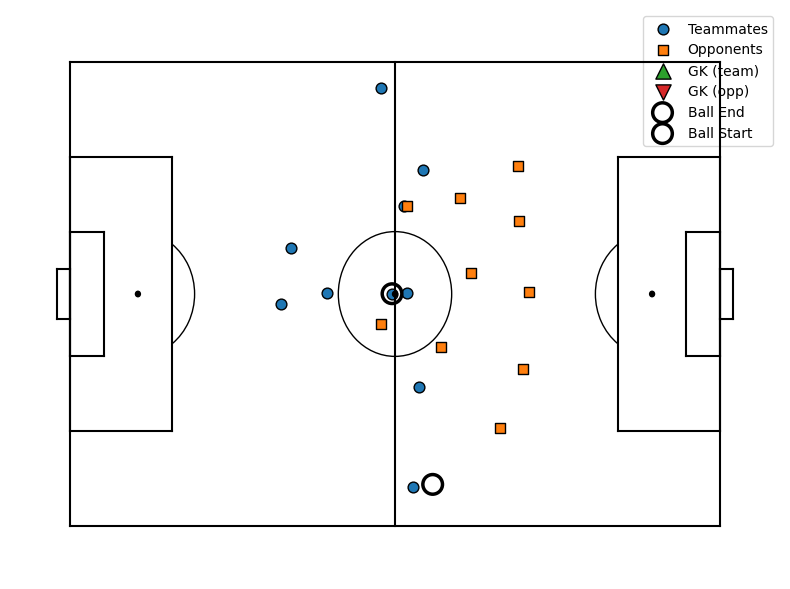

In [8]:
import matplotsoccer as mps
# Gather points
xs_tm, ys_tm = [], []
xs_op, ys_op = [], []
xs_gk_tm, ys_gk_tm = [], []
xs_gk_op, ys_gk_op = [], []
actor_xy = None

for p in transformed_threesixty:
    x, y = p["location_spadl"]
    if p["actor"]:
        actor_xy = (x, y)

    if p["keeper"]:
        if p["teammate"]:
            xs_gk_tm.append(x); ys_gk_tm.append(y)
        else:
            xs_gk_op.append(x); ys_gk_op.append(y)
    else:
        if p["teammate"]:
            xs_tm.append(x); ys_tm.append(y)
        else:
            xs_op.append(x); ys_op.append(y)


            
# Plot non-keepers
mps.field(figsize=8, show=False)

plt.scatter(xs_tm, ys_tm, label="Teammates", s=60, edgecolors="black", zorder=3)
plt.scatter(xs_op, ys_op, label="Opponents", s=60, marker="s", edgecolors="black", zorder=3)

# Plot keepers
plt.scatter(xs_gk_tm, ys_gk_tm, label="GK (team)", s=120, marker="^", edgecolors="black", zorder=4)
plt.scatter(xs_gk_op, ys_gk_op, label="GK (opp)", s=120, marker="v", edgecolors="black", zorder=4)


plt.scatter([spadl_end_location[0]], [spadl_end_location[1]], s=200, facecolors="none", edgecolors="black", linewidths=2.5, zorder=5, label="Ball End")


plt.scatter([actor_xy[0]], [actor_xy[1]], s=200, facecolors="none", edgecolors="black", linewidths=2.5, zorder=5, label="Ball Start")


plt.legend(loc="upper right")
plt.tight_layout()
plt.show()


Now I should think of how I might design the features of the state space. Things I may want to use are:

- sparse team in possession/out of posession matrix (105,68)
- dense distance to ball and goal of every grid (105,68)
- Two dense matrices containing the sine and cosine of the angle between every location to the goal and the ball location
- one dense matrix containing the angle in radians to the goal location.


for velocity vectors it would be difficult to say with poor temporal data

Sparse team in possession/out of possession matrix (105,68)

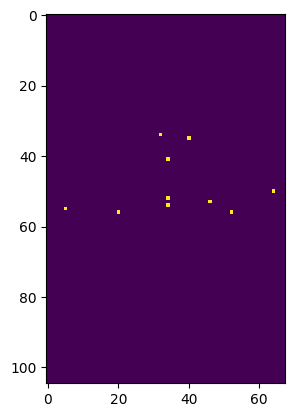

In [9]:
import torch

FL, FW = 105, 68  # grid size in meters → cells

def players_to_onehot(xs, ys, H=FL, W=FW, method="floor", sparse=False, device=None, dtype=torch.float32):
    """
    xs, ys: iterables of player coordinates in meters (0..105, 0..68)
    H, W:   output grid size (rows=y along 0..H-1, cols=x along 0..W-1)
    method: 'floor' (default) or 'round' for discretization
    sparse: if True, returns a torch.sparse_coo_tensor; else a dense tensor
    """
    x = torch.tensor(xs, dtype=torch.float32, device=device)
    y = torch.tensor(ys, dtype=torch.float32, device=device)

    if method == "round":
        xi = torch.round(x).to(torch.long)
        yi = torch.round(y).to(torch.long)
    else:
        xi = torch.floor(x).to(torch.long)
        yi = torch.floor(y).to(torch.long)

    xi = xi.clamp_(0, H - 1)
    yi = yi.clamp_(0, W - 1)

    if sparse:
        idx = torch.stack([xi, yi], dim=0)
        vals = torch.ones(len(xi), dtype=dtype, device=device)
        # if duplicates exist, coalesce will sum; clamp to 1 after if you want strict one-hot
        sp = torch.sparse_coo_tensor(idx, vals, size=(H, W), device=device, dtype=dtype).coalesce()
        print(sp)
        # enforce binary:
        sp = torch.sparse_coo_tensor(sp.indices(), torch.clamp(sp.values(), max=1), (H, W), device=device, dtype=dtype)
        return sp

    grid = torch.zeros((H, W), dtype=dtype, device=device)
    grid[xi, yi] = 1.0 
    return grid

teammates_mat = players_to_onehot(xs_tm,ys_tm, sparse = False)
opponents_mat = players_to_onehot(xs_op,ys_op, sparse = False)

plt.imshow(teammates_mat)

dense distance to ball and goal of every grid (105,68)

In [10]:
import numpy as np
from mplsoccer import Pitch

def point_distance_map(x, y, H=105, W=68, device=None, dtype=torch.float32, normalized=False):
    """
    Returns a (H, W) tensor where entry [i, j] is the distance (in meters) from cell (x=i, y=j) to (x, y).

    x, y: ball location in meters (floats, 0<=x<=H, 0<=y<=W). Values outside will still work.
    H, W: grid size; we use row=x in [0..H-1], col=y in [0..W-1] to match (105,68).
    squared: if True, returns squared Euclidean distance.
    normalized: if True, divide by the max possible distance on the grid (corner-to-corner).

    Notes:
    - Fully differentiable; no loops.
    - If you prefer conventional row=y, col=x indexing, swap the dx/dy grids below.
    """
    xs = torch.arange(H, device=device, dtype=dtype).unsqueeze(1)  # shape (H, 1)
    ys = torch.arange(W, device=device, dtype=dtype).unsqueeze(0)  # shape (1, W)

    dx = xs - torch.as_tensor(x, device=device, dtype=dtype)  # (H, 1)
    dy = ys - torch.as_tensor(y, device=device, dtype=dtype)  # (1, W)


    dist = torch.hypot(dx, dy)

    """if normalized: Should I normalize or will batch norm take care of this for me? 
        max_d = torch.hypot(torch.tensor(H-1, dtype=dtype, device=device),
                            torch.tensor(W-1, dtype=dtype, device=device))
        dist = dist / max_d"""

    return dist  # shape (H, W)

ball_dis_mat = point_distance_map(actor_xy[0],actor_xy[1])

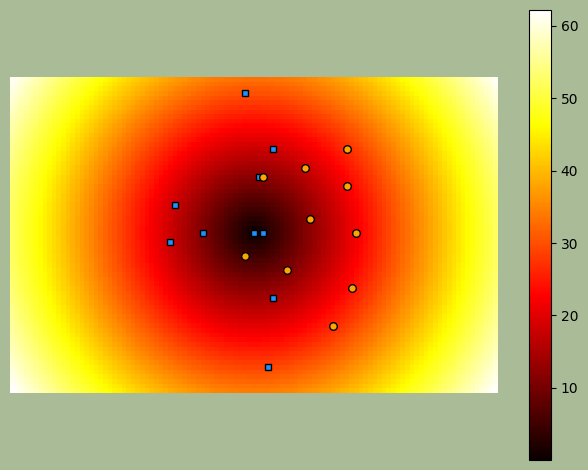

In [11]:
from utils.visualizer import SoccerVisualizer

visualizer = SoccerVisualizer()

fig, ax, artists = visualizer.plot_state(teammates_mat,opponents_mat,heatmap=ball_dis_mat)
plt.show()
